# CS 542 Fall 2024 Midterm

Your task for this midterm is to build a model detecting trees in images.
This repository includes approximately 500 pictures.
Most of them are from the Boston area, but some are from around the globe.
Most of them were taken outside, but some were taken inside or in more exotic locations.
Many other factors such as lighting, weather, and confounding bushes will make this a challenging problem.

* 70% of the grade will be based on the model that you build.
  * This portion of the grade will heavily driven by your model's performance on the test data.
* 30% will be based on answering questions about your model and your process.

The baseline code has trouble consistently achieving 70% accuracy on the validation set.
* If you achieve 75% accuracy on the test set, that will be worth at least 80% for the model component of your grade.
* If you achieve 80% accuracy on the test set, that will be worth at least 90% for the model component of your grade.

When you are done, submit both this notebook and the output file of test predictions to Gradescope.

In [89]:
!pip install --quiet imageio livelossplot torcheval

In [90]:
import imageio.v2 as imageio
import livelossplot
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torcheval.metrics

In [91]:
def to_gpu(t):
    if torch.cuda.is_available():
        return t.cuda()
    return t

def to_numpy(t):
    return t.detach().cpu().numpy()

device = to_gpu(torch.ones(1,1)).device
device

device(type='cpu')

## Model Building (70 points)

Change any of the code below to build a better model.
Your model will primarily be graded on predictions on the test set.
Be sure to include your model's test predictions when you submit to Gradescope.

In [92]:
# the repository has images scaled to standard widths of 64, 128 and 256.
# you may use larger images if you prefer.

image_width = 64

def load_data_set(data_set_name):
    labels = pd.read_csv(f"{data_set_name}.tsv", sep="\t")

    file_names = []
    images = []
    targets = []
    for i in range(labels.shape[0]):
        row = labels.iloc[i]
        try:
            image = imageio.imread(f"images{image_width}/{row['filename']}")[...]
        except:
            print("SKIPPING ", row['filename'], "MISSING")
            continue

        if image.shape[0] != image.shape[1] * 3 // 4:
            print("SKIPPING ", row['filename'], image.shape)
            continue

        # convert from 0-255 to 0.0-1.0
        image = image / 255
        # prepend axis with length one
        # image = image.reshape(1, *image.shape)
        image = torch.Tensor(image, device=device)
        # permute image dimensions to put color channel first
        image = torch.permute(image, [2, 0, 1])

        file_names.append(row['filename'])
        images.append(image)
        targets.append(row["target"])

    images = torch.stack(images)

    targets = torch.Tensor(targets, device=device)
    targets = targets.long()

    return (file_names, images, targets)

train_data_set = load_data_set("train")
for t in train_data_set[1:]:
    print("TRAIN", t.shape, t.dtype)
(train_file_names, train_X, train_Y) = train_data_set

validation_data_set = load_data_set("validation")
for t in validation_data_set[1:]:
    print("VALIDATION", t.shape, t.dtype)
(validation_file_names, validation_X, validation_Y) = validation_data_set

SKIPPING  IMG_1026.png MISSING
SKIPPING  IMG_1105.png MISSING
SKIPPING  IMG_1106.png MISSING
SKIPPING  IMG_1109.png MISSING
SKIPPING  IMG_1110.png MISSING
SKIPPING  IMG_1111.png MISSING
SKIPPING  IMG_1116.png MISSING
SKIPPING  IMG_1119.png MISSING
TRAIN torch.Size([292, 3, 48, 64]) torch.float32
TRAIN torch.Size([292]) torch.int64
SKIPPING  IMG_1107.png MISSING
SKIPPING  IMG_1112.png MISSING
SKIPPING  IMG_1117.png MISSING
VALIDATION torch.Size([97, 3, 48, 64]) torch.float32
VALIDATION torch.Size([97]) torch.int64


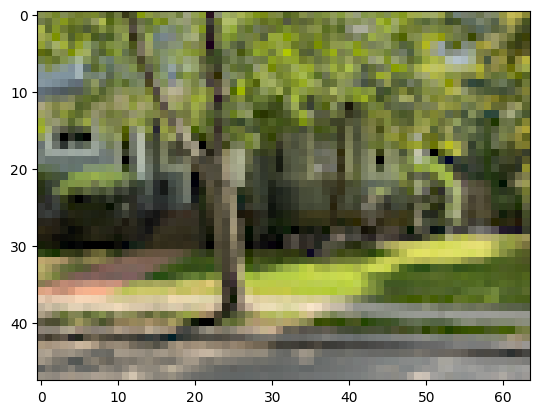

In [93]:
plt.imshow(to_numpy(torch.permute(train_X[0,:,:,:], (1, 2, 0))))

In [94]:
class TreeNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_0 = torch.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, device=device)
        self.conv_1 = torch.nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, stride=2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=5, out_channels=5, kernel_size=1, device=device)
        self.fc_3 = torch.nn.Linear(700, 2)

        self.relu = torch.nn.ReLU()

    def forward(self, X):

        X = self.conv_0(X)
        X = self.relu(X)

        X = self.conv_1(X)
        X = self.relu(X)

        X = self.conv_2(X)
        X = self.relu(X)
 
        # flatten channels and image dimensions
        X = X.reshape(X.shape[:-3] + (-1,))

        X = self.fc_3(X)

        return X

test_model = TreeNetwork()
test_output = test_model(train_X[:5,:,:,:])
assert test_output.shape == (5, 2)
del test_output

In [95]:
loss_function = torch.nn.CrossEntropyLoss()

In [96]:
DEFAULT_EPOCHS = 1000 if torch.cuda.is_available() else 100

def train_model(model_class, epochs=DEFAULT_EPOCHS, learning_rate=1e-4, **kwargs):
    model = model_class(**kwargs)
    try:
        model = model.cuda()
    except:
        print("cuda() failed")
    model = torch.nn.DataParallel(model)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    liveloss = livelossplot.PlotLosses()
    for i in range(epochs):
        model.train()

        optimizer.zero_grad(set_to_none=True)
        prediction = model(train_X)
        loss = loss_function(prediction, train_Y)
        loss.backward()
        optimizer.step()

        if (i + 1) % 2 == 0:
            liveloss_updates = {}
            with torch.no_grad():
                model.eval()

                def get_metrics(metrics_prefix, metrics_X, metrics_Y):
                    metrics_prediction = model(metrics_X)

                    return {
                        f"{metrics_prefix}loss": loss_function(metrics_prediction, metrics_Y),
                        f"{metrics_prefix}accuracy": torcheval.metrics.functional.multiclass_accuracy(torch.argmax(metrics_prediction, dim=-1), metrics_Y)
                    }
                
                liveloss_updates.update(get_metrics("", train_X, train_Y))
                liveloss_updates.update(get_metrics("val_", validation_X, validation_Y))

            liveloss_updates = {k: to_numpy(v) for k, v in liveloss_updates.items()}
            liveloss.update(liveloss_updates,
                            current_step=i+1)
            liveloss.send()

    return model

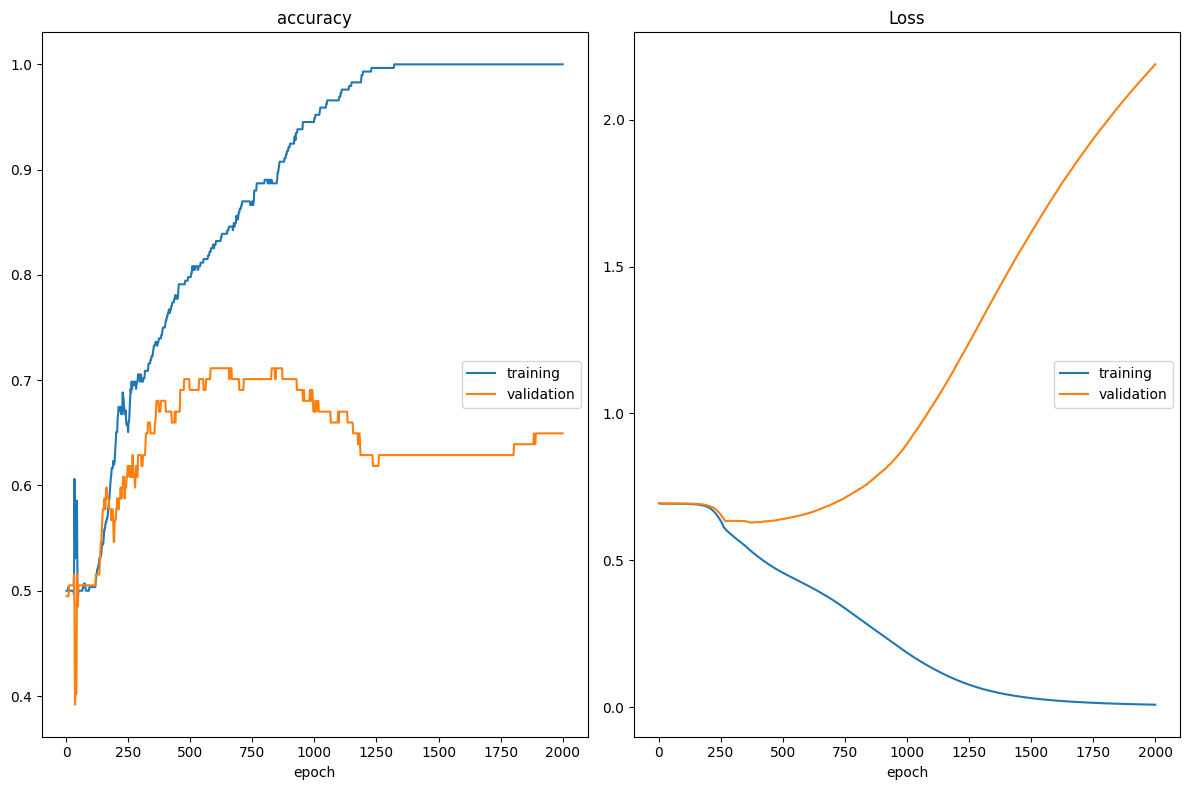

accuracy
	training         	 (min:    0.493, max:    1.000, cur:    1.000)
	validation       	 (min:    0.392, max:    0.711, cur:    0.649)
Loss
	training         	 (min:    0.008, max:    0.694, cur:    0.008)
	validation       	 (min:    0.628, max:    2.189, cur:    2.189)


In [97]:
tree_model = train_model(TreeNetwork, epochs=2000)

In [98]:
test_data_set = load_data_set("test")
(test_file_names, test_X, test_Y) = test_data_set

SKIPPING  IMG_1108.png (86, 64, 3)
SKIPPING  IMG_1113.png (86, 64, 3)
SKIPPING  IMG_1118.png (86, 64, 3)


In [99]:
with torch.no_grad():
    tree_model.eval()

    test_prediction = tree_model(test_X)

test_prediction = to_numpy(test_prediction)
with open("test-output.tsv", "w") as test_fp:
    test_fp.write("filename\tlogit_0\tlogit_1\tprediction\n")

    for (test_filename, (logit_0, logit_1)) in zip(test_file_names, test_prediction):
        prediction = 1 if logit_1 > logit_0 else 0
        test_fp.write(f"{test_filename}\t{logit_0:.6f}\t{logit_1:.6f}\t{prediction}\n")

In [100]:
!head test-output.tsv

filename	logit_0	logit_1	prediction
IMG_0184.png	2.807629	-2.825269	0
IMG_0204.png	-1.284385	0.156706	1
IMG_0209.png	-2.648744	1.182329	1
IMG_0296.png	1.346548	-2.388234	0
IMG_0319.png	0.956732	-2.064032	0
IMG_0331.png	2.633625	-3.262159	0
IMG_0369.png	0.946691	-2.389896	0
IMG_0437.png	2.851386	-4.091246	0
IMG_0585.png	0.338255	-2.099931	0


### What aspects of your model design helped fit the training the data the most? (10 points)

How did you change the base model to fit the training data better?
More quickly?
Can you quantify the benefits of those changes?

## Questions

YOUR ANSWER HERE

### What did you do to manage overfitting? (10 points)

Please elaborate on your model design choices to reduce overfitting.
How much did these choices appear to help?

YOUR ANSWER HERE

### In your opinion, what factor held back your model performance the most? (5 points)

YOUR ANSWER HERE

### If you were given an extra week to work on this model, what would you do? (2 points)

YOUR ANSWER HERE

### What was the most interesting image in the data set that you noticed? (3 points)

Do you think it made the modeling process easier or harder?

YOUR ANSWER HERE